## Importing packages

In [1]:
"""
! pip3 install seaborn 
! pip3 install scipy
! pip3 install matplotlib
! pip3 install sklearn
! pip3 install warnings
! pip3 install statsmodels
! pip3 install patsy
"""

'\n! pip3 install seaborn \n! pip3 install scipy\n! pip3 install matplotlib\n! pip3 install sklearn\n! pip3 install warnings\n! pip3 install statsmodels\n! pip3 install patsy\n'

In [2]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
from matplotlib import cm

from scipy.special import inv_boxcox

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, Normalizer, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_confusion_matrix


import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from patsy import dmatrices
import statsmodels.api as sm

from scipy.stats import chi2_contingency

## Loading data

Defining X (features) and y (target variable) and standardizing column headers before we move on...

In [3]:
df = pd.read_csv("data/creditcardmarketing.csv")

In [4]:
def clean_headers(df):
    cols = []
    for c in df.columns:
        c = c.lower().replace(" ", "_").replace("#", "n")
        cols.append(c)
    df.columns = cols


In [5]:
clean_headers(df)

## Exploring data

In [6]:
df.shape

(18000, 17)

In [7]:
pd.set_option('display.max_columns', None)
df.head(3)

,customer_number,offer_accepted,reward,mailer_type,income_level,n_bank_accounts_open,overdraft_protection,credit_rating,n_credit_cards_held,n_homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0


### Exploring Categoricals

In [8]:
df_cat = df.select_dtypes('object')
df_cat.head()

,offer_accepted,reward,mailer_type,income_level,overdraft_protection,credit_rating,own_your_home
0,No,Air Miles,Letter,High,No,High,No
1,No,Air Miles,Letter,Medium,No,Medium,Yes
2,No,Air Miles,Postcard,High,No,Medium,Yes
3,No,Air Miles,Letter,Medium,No,High,No
4,No,Air Miles,Letter,Medium,No,Medium,Yes


#### Lets see the number of distinct values each column has and what % of the total values belong to each type.

In [9]:
def cat_exploration(df):
    cat = df.select_dtypes('object')
    for c in cat.columns:
        sns.set_style("darkgrid")
        print(c)
        print(cat[c].value_counts(normalize=True).mul(100).round(1))
        fig, axes = plt.subplots(1, 1, figsize=(7, 4))
        sns.countplot(cat[c], color = 'gray')
        plt.show()

offer_accepted
No     94.3
Yes     5.7
Name: offer_accepted, dtype: float64


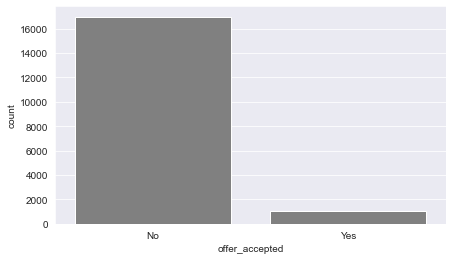

reward
Air Miles    33.7
Cash Back    33.3
Points       33.0
Name: reward, dtype: float64


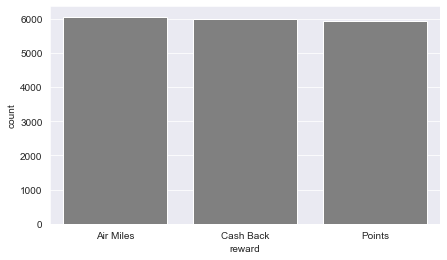

mailer_type
Postcard    50.8
Letter      49.2
Name: mailer_type, dtype: float64


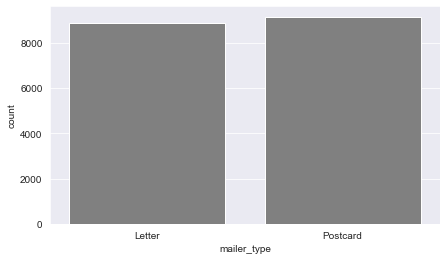

income_level
Medium    50.1
High      25.1
Low       24.8
Name: income_level, dtype: float64


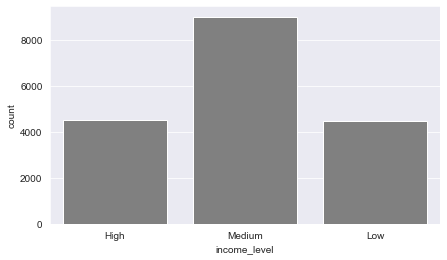

overdraft_protection
No     85.1
Yes    14.9
Name: overdraft_protection, dtype: float64


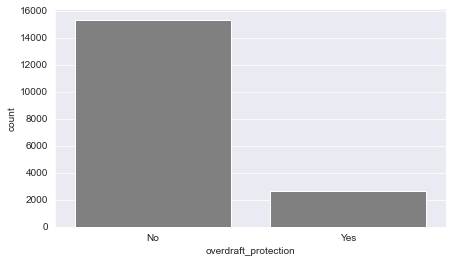

credit_rating
High      33.7
Medium    33.2
Low       33.1
Name: credit_rating, dtype: float64


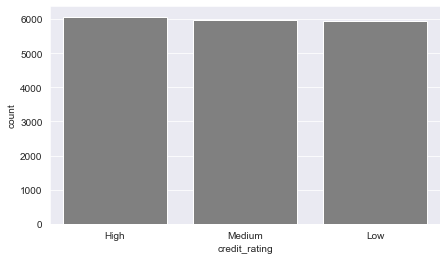

own_your_home
Yes    64.8
No     35.2
Name: own_your_home, dtype: float64


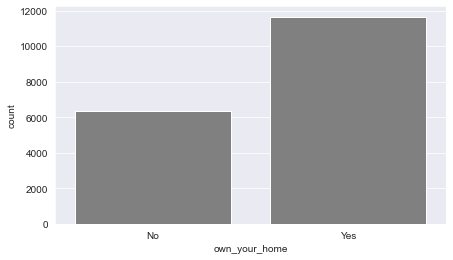

In [10]:
cat_exploration(df)

Takeaways:
- There isn't any categorical column with too many different value types which might require bucketing.
- The largest imbalance occurs with our target variable: "offer_accepted"

### Exploring numericals

In [11]:
def num_exploration(df):
    num = df.select_dtypes('number')
    for c in num.columns:
        print(c)
        fig, axes = plt.subplots(1, 2, figsize=(10, 3))
        sns.set_style("dark")
        sns.distplot(num[c], ax=axes[0],  color = 'gray')
        sns.boxplot(num[c], ax=axes[1],  color = 'gray')
        plt.show()
    sns.pairplot(num)
    plt.show()
    return num.describe().apply(lambda x: round(x,2))

customer_number


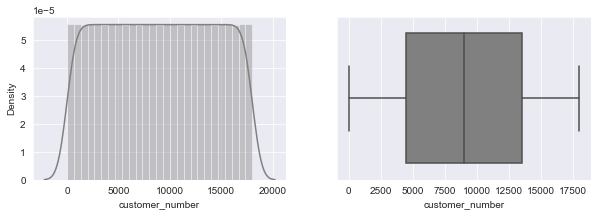

n_bank_accounts_open


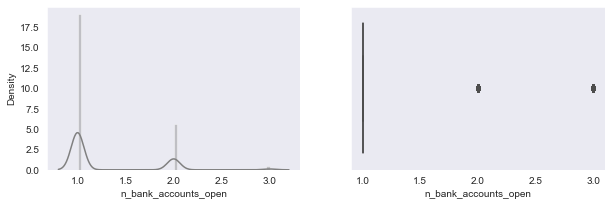

n_credit_cards_held


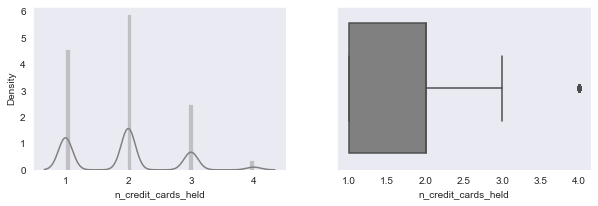

n_homes_owned


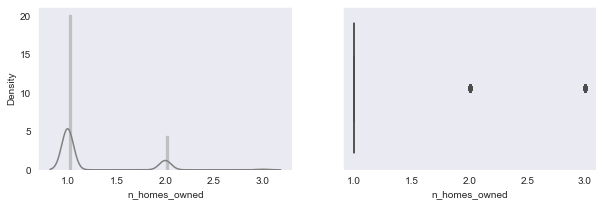

household_size


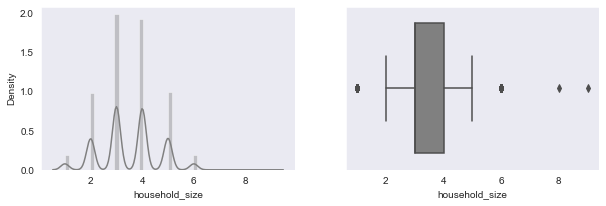

average_balance


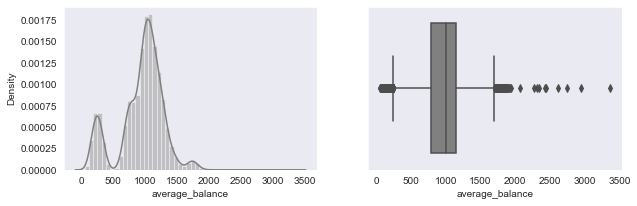

q1_balance


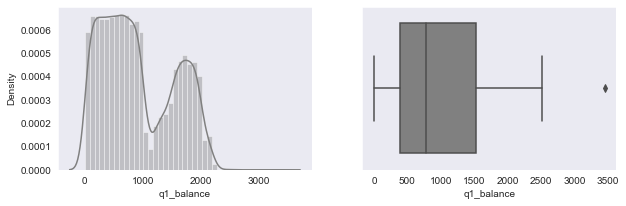

q2_balance


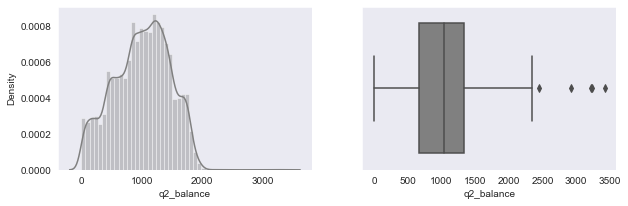

q3_balance


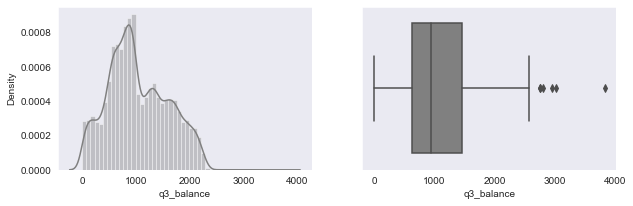

q4_balance


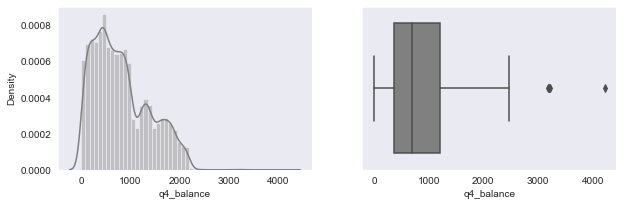

KeyboardInterrupt: 

In [12]:
num_exploration(df)

## Check correlations:

We are checking the correlation of the data by also creating modifications of the original one by dropping certain columns that have a lot of correlation. We will later see how do they dirrerently affect the model.

We create the different dfs

In [13]:
df1 = df.drop('average_balance', axis=1)
df2 = df.drop(['q1_balance','q2_balance','q3_balance','q4_balance'], axis=1)


We define the three correlation matrixes

In [14]:
corr_matrix=df.corr(method='pearson')
corr_matrix1=df1.corr(method='pearson')
corr_matrix2=df2.corr(method='pearson')

We plot them:

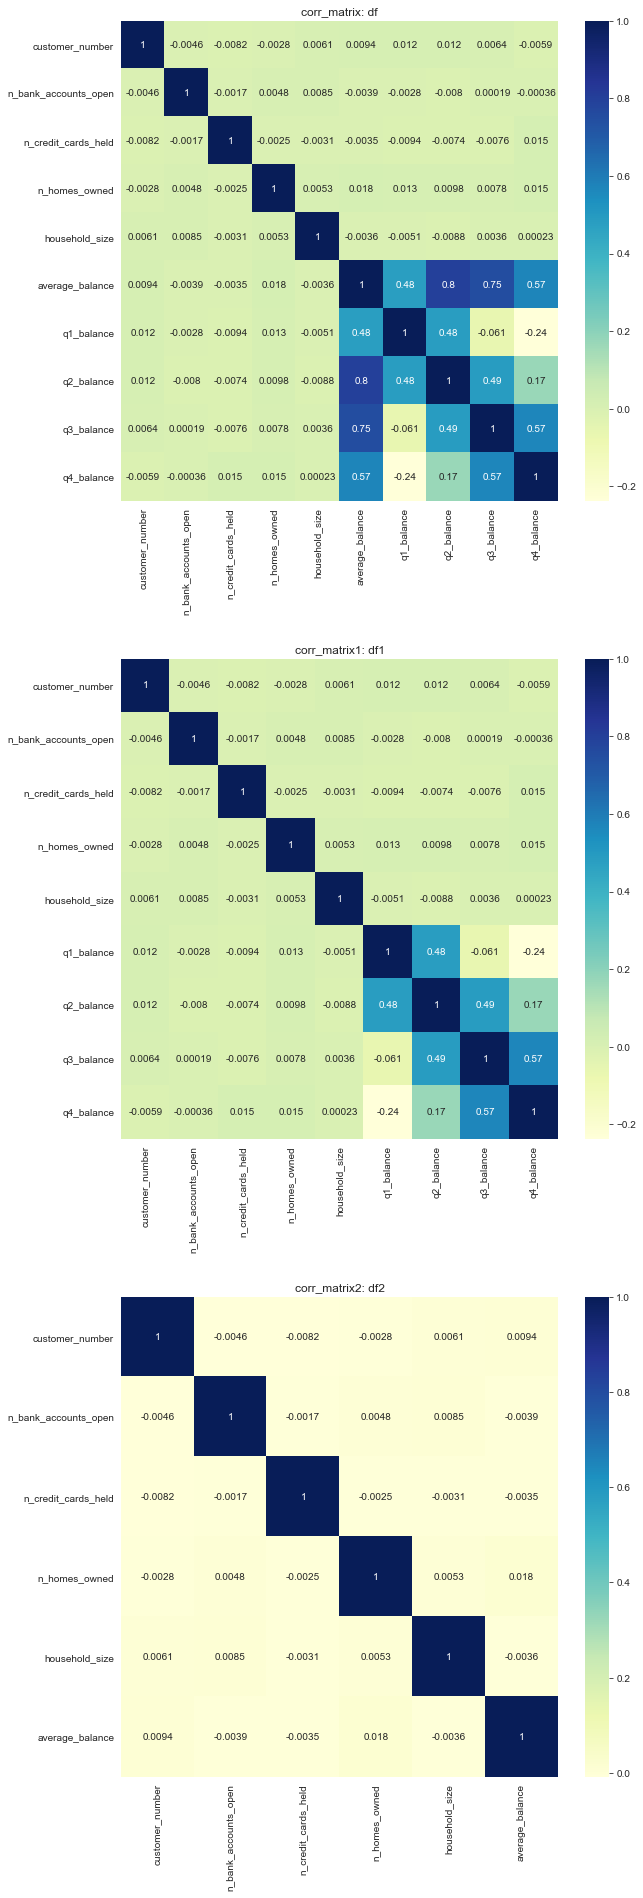

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10, 27))

sns.heatmap(corr_matrix, ax=ax1, annot=True, cmap="YlGnBu")
sns.heatmap(corr_matrix1, ax=ax2, annot=True, cmap="YlGnBu")
sns.heatmap(corr_matrix2, ax=ax3, annot=True, cmap="YlGnBu")

ax1.set_title('corr_matrix: df')
ax2.set_title('corr_matrix1: df1')
ax3.set_title('corr_matrix2: df2')
fig.tight_layout(pad=3.0)


plt.show()

### Checking null values:

In [16]:
def checking_nulls(df):
    for c in df.columns:
        null_count = df[c].isnull().sum()
        if null_count > 0:
            print ("The column ", c, " has ", null_count, " null values")
    nulls = df[df.isna().any(axis=1)]
    return nulls.head()

In [17]:
checking_nulls(df)

The column  average_balance  has  24  null values
The column  q1_balance  has  24  null values
The column  q2_balance  has  24  null values
The column  q3_balance  has  24  null values
The column  q4_balance  has  24  null values


,customer_number,offer_accepted,reward,mailer_type,income_level,n_bank_accounts_open,overdraft_protection,credit_rating,n_credit_cards_held,n_homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
323,324,No,Points,Postcard,Medium,1,No,High,1,1,4,No,NaN,NaN,NaN,NaN,NaN
3070,3071,Yes,Air Miles,Postcard,Low,3,No,Medium,2,1,4,Yes,NaN,NaN,NaN,NaN,NaN
3108,3109,No,Air Miles,Letter,Low,1,No,High,3,1,4,Yes,NaN,NaN,NaN,NaN,NaN
3789,3790,No,Air Miles,Letter,Medium,2,No,High,3,1,3,No,NaN,NaN,NaN,NaN,NaN
5083,5084,No,Points,Letter,Medium,1,No,High,1,1,3,Yes,NaN,NaN,NaN,NaN,NaN


We will deal with null values later.

## Cleaning data

### Dealing with irrelevant columns

customer_number is important for the predictions, but i won't use it as a feature (unique values)


In [18]:
df = df.set_index('customer_number')

### Dealing with null values

- We will replace null values with the mean as the data distribution for columns with null values is "slightly" normal (see previous graphs)

In [19]:
def replace_nulls_mean(df):
    for c in df.columns:
        null_count = df[c].isnull().sum()
        if null_count > 0:
            df[c].fillna((df[c].mean()), inplace=True)
    return df

In [20]:
df = replace_nulls_mean(df)
checking_nulls(df)

,offer_accepted,reward,mailer_type,income_level,n_bank_accounts_open,overdraft_protection,credit_rating,n_credit_cards_held,n_homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
customer_number,,,,,,,,,,,,,,,,


## Multicollinearity analysis

In [21]:
features = "+".join(['reward', 'mailer_type', 'income_level',
       'n_bank_accounts_open', 'overdraft_protection', 'credit_rating',
       'n_credit_cards_held', 'n_homes_owned', 'household_size',
       'own_your_home', 'average_balance', 'q1_balance', 'q2_balance',
       'q3_balance', 'q4_balance'])

y_enc, X_enc = dmatrices('offer_accepted ~' + features, df, return_type='dataframe')

In [22]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_enc.values, i) for i in range(X_enc.shape[1])]
vif["features"] = X_enc.columns

vif.round(2)

,VIF Factor,features
0,48.51,Intercept
1,1.33,reward[T.Cash Back]
2,1.33,reward[T.Points]
3,1.00,mailer_type[T.Postcard]
4,1.50,income_level[T.Low]
5,1.49,income_level[T.Medium]
6,1.00,overdraft_protection[T.Yes]
7,1.33,credit_rating[T.Low]
8,1.33,credit_rating[T.Medium]
9,1.00,own_your_home[T.Yes]


## Chi Square test

In [23]:
def chi_square_test(df):
    cat = df.select_dtypes('object')    
    cols = cat.columns
    for i in cols:
        for j in cols:
            if i != j:
                data_crosstab = pd.crosstab(df[i], df[j], margins = False)
                chi2_stat, p_val, dof, ex = stats.chi2_contingency(data_crosstab, correction=False)
                print("The chi2_contingency for ", i, " and ", j," is:" )
                print("===Chi2 Stat===")
                print(chi2_stat)
                print("===Degrees of Freedom===")
                print(dof)
                print("===P-Value===")
                print(float(p_val))
                print ("{:.60f}".format(float(p_val)))
                print("===Contingency Table===")
                print(ex)
                print("\n")            

In [24]:
chi_square_test(df)

The chi2_contingency for  offer_accepted  and  reward  is:
===Chi2 Stat===
101.99764699462307
===Degrees of Freedom===
2
===P-Value===
7.103826919269613e-23
0.000000000000000000000071038269192696131431567758035302233757
===Contingency Table===
[[5716.53316667 5658.05683333 5602.41      ]
 [ 344.46683333  340.94316667  337.59      ]]


The chi2_contingency for  offer_accepted  and  mailer_type  is:
===Chi2 Stat===
171.13002056177373
===Degrees of Freedom===
1
===P-Value===
4.1914413632040166e-39
0.000000000000000000000000000000000000004191441363204016647996
===Contingency Table===
[[8349.8545 8627.1455]
 [ 503.1455  519.8545]]


The chi2_contingency for  offer_accepted  and  income_level  is:
===Chi2 Stat===
114.36759816901265
===Degrees of Freedom===
2
===P-Value===
1.463496214215802e-25
0.000000000000000000000000146349621421580189838762807252342152
===Contingency Table===
[[4268.77233333 4207.4665     8500.76116667]
 [ 257.22766667  253.5335      512.23883333]]


The chi2_contingency 

## Preparing data to fit the model

In [25]:
X = df.drop('offer_accepted', axis=1)
y = df['offer_accepted']

Separating numericals from categoricals in X

In [26]:
X_cat = X.select_dtypes('object')
X_num = X.select_dtypes('number')

Encoding categoricals

In [27]:
X_cat_enc = pd.get_dummies(X_cat, drop_first=True)
y_enc = pd.get_dummies(y, drop_first=True)

In [28]:
X_model = np.concatenate([X_num, X_cat_enc], axis=1)
y_model = y_enc

## Create Training and Test Sets and Apply Scaling

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, random_state=0)

## Building models

### Logistic regression

In [30]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [31]:
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.94
Accuracy of Logistic regression classifier on test set: 0.94


In [32]:
score = logreg.score(X_test, y_test)
score

0.94

In [33]:
y_pred = logreg.predict(X_test)

In [34]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[4229    2]
 [ 268    1]]


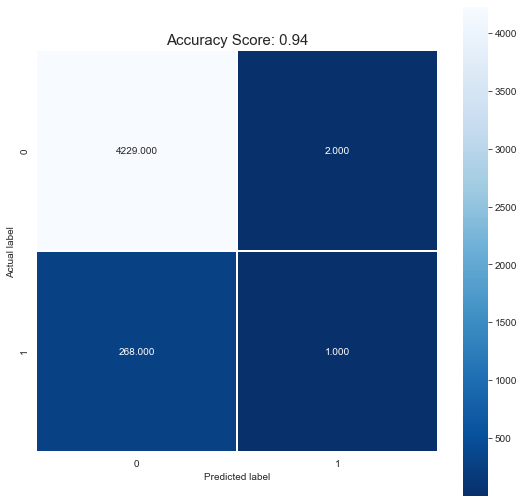

In [35]:
plt.figure(figsize=(9,9))
sns.heatmap(confusion_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4231
           1       0.33      0.00      0.01       269

    accuracy                           0.94      4500
   macro avg       0.64      0.50      0.49      4500
weighted avg       0.90      0.94      0.91      4500



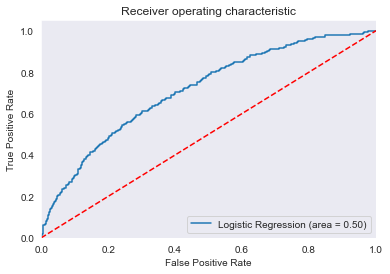

In [37]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()